<a href="https://colab.research.google.com/github/suchy1713/EmotionPredicition/blob/master/result_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now let's try to understand the results and find the most important features. To do this we will use the SHAP package. SHAP analyses every single row of data to see how changes in features impact predictions.

Legend:<br>
-> p - photo<br>
-> s - sound<br>
-> + - positive valence and high arousal<br>
-> 0 - neutral valence and medium arousal<br>
-> - - negative valence and high arousal<br>

In [0]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('https://raw.githubusercontent.com/suchy1713/EmotionPredicition/master/data/preprocessed/data_exp.csv')
X = df.drop(['ANS_1.0', 'ANS_2.0', 'ANS_3.0', 'ANS_4.0','ANS_5.0'], axis=1)
y = df[['ANS_1.0', 'ANS_2.0', 'ANS_3.0', 'ANS_4.0','ANS_5.0']].idxmax(axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

best_model = xgb.XGBClassifier(max_depth=3, min_child_weight=7, subsample=0.85, colsample_bytree=0.71, learning_rate=0.264, n_estimators=250)
best_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.71, gamma=0,
              learning_rate=0.264, max_delta_step=0, max_depth=3,
              min_child_weight=7, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.85, verbosity=1)

In [0]:
!pip install shap

     |████████████████████████████████| 266kB 3.5MB/s 
  Created wheel for shap: filename=shap-0.34.0-cp36-cp36m-linux_x86_64.whl size=383174 sha256=03348507101d7b057f90703c99af2dba78cf9e18aca868bde2a3356e666c50d3
  Stored in directory: /root/.cache/pip/wheels/28/7e/28/57bc9fcb77579b0df6561298648249370648c0b91dfe42c8ec
Successfully built shap


VARIABLE IMPORTANCE PLOT lists the most significant features in descending order:

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


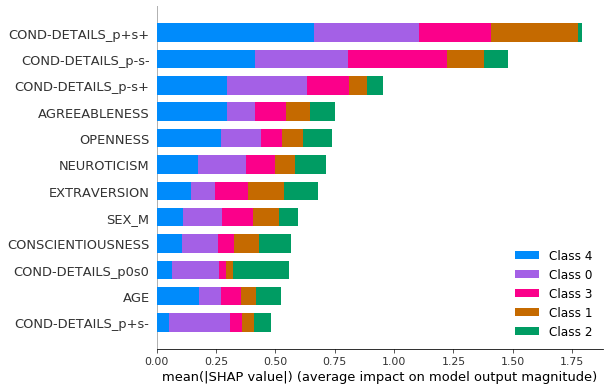

In [0]:
import shap

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

There is no surprise here. Features describing the photo and sound type have the biggest impact on the model output (p+s+, p-s-, p-s+). However, as it turned out, p0s0 and p+s- are not that important. As you'd expect, sex and age are not significant at all. Psychological traits like openness, agreeableness and extraversion seem to have some impact, especially for extreme faces (D: and :D).

Now let's examine positive and negative relationships of the features with targets for every class separately.

<b>Class 0 - D:</b>

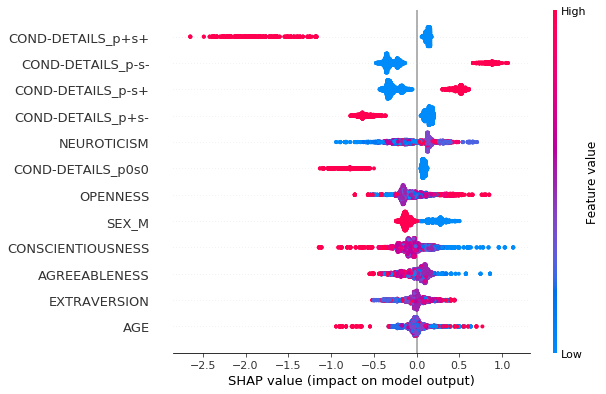

In [0]:
shap.summary_plot(shap_values[0], X_test)

Subjects presented with p-s- or p-s+ or not presented with p+s+ or not presented p+s- were more likely to choose emoticon 'D:'. It may indicate that photos had bigger impact on their decisions than sounds.

It doesn't look like any psychological trait have a clear corellation with an output.

<b>Class 1 - ):</b>

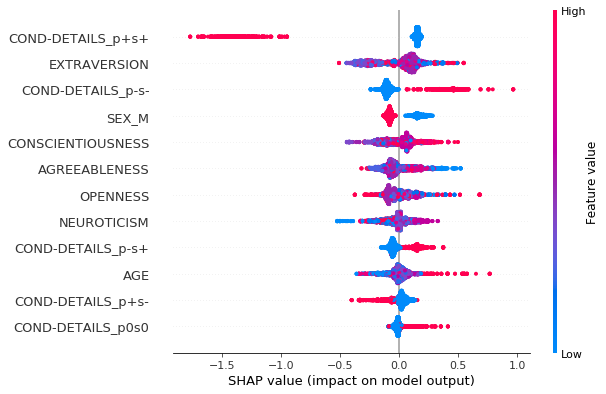

In [0]:
shap.summary_plot(shap_values[1], X_test)

We can see that being presented with p-s- or not being presented with p+s+ increase probability of choosing the '):' emoticon.

<b>Class 2 - |:<b>

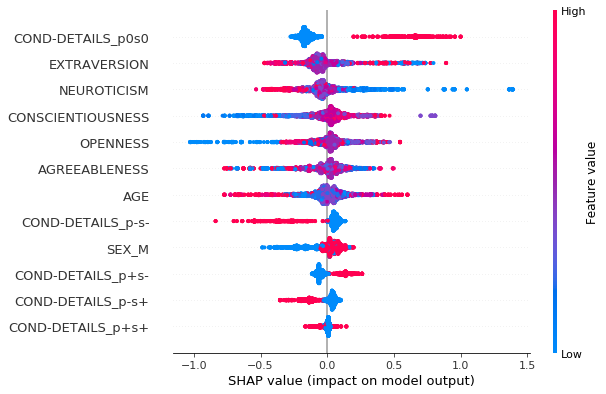

In [0]:
shap.summary_plot(shap_values[2], X_test)

Again - no surprise. Being presented with neutral photo and neutral sound is the most significant predictor for this class. But, interestingly, we can see some negative corellation between neuroticism and the model output (we'll examine it later).

<b>Class 3 - :)<b>

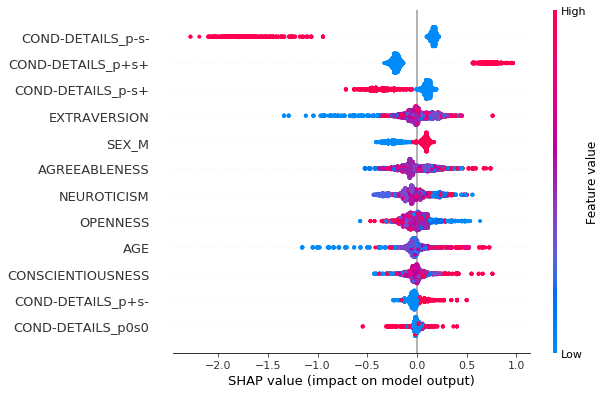

In [0]:
shap.summary_plot(shap_values[3], X_test)

Subjects presented with p+s+ or not presented with p-s- were more likely to choose ':)' emoticon.

<b>Class 4 - :D<b>

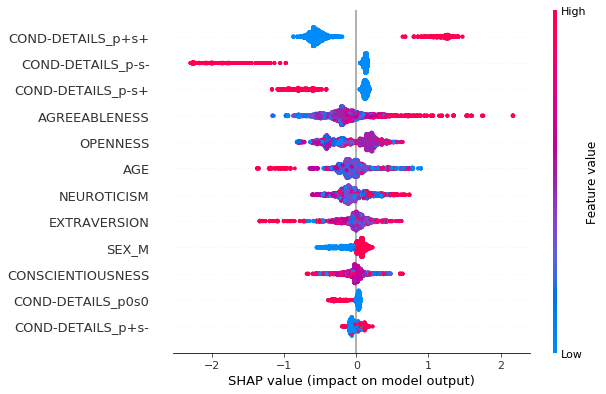

In [0]:
shap.summary_plot(shap_values[4], X_test)

And again, being presented with p+s+ or not being presented with p-s- have the biggest impact. What's more, agreableness seem to correlate with an output.

Let's examine that more closely using a partial dependence plot:

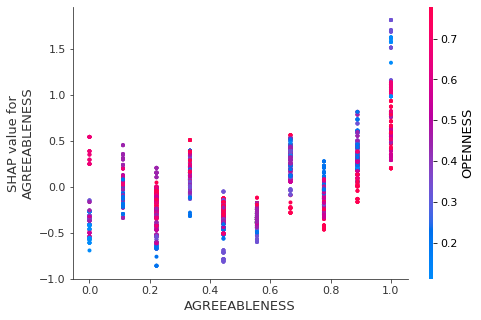

In [0]:
shap.dependence_plot("AGREEABLENESS", shap_values[4], X_test)

So as we can see, subjects with high agreableness were more likely to choose ':D' emoticon.

Now let's see the neuroticism and output for class ':|' correlation:

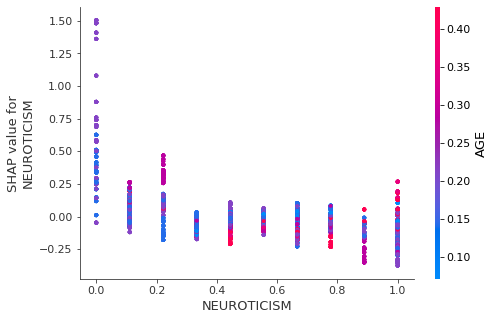

In [0]:
shap.dependence_plot("NEUROTICISM", shap_values[2], X_test)

It's subtle but subjects with very low neuroticism were slightly more likely to choose the ':|' emoticon.

And for the final trick, SHAP allows us to visualise model decision making for a single prediction. Let's do it for a random sample and see whether it makes sense. We will get 5 plots - one for each class. Features shown in red are increasing the prediction probability (pushing it to the right), and those in blue are deacreasing the probability (pushing to the left).

In [0]:
sample = X_test.sample(random_state=86)
single_explainer = shap.TreeExplainer(best_model)
single_shap_values = single_explainer.shap_values(sample)

shap.initjs()
for i in range(0, 5):
    display(shap.force_plot(single_explainer.expected_value[i], single_shap_values[i], sample))

res = pd.concat([pd.DataFrame(data=single_shap_values[0], columns=X_test.columns, index=[0]),
                 pd.DataFrame(data=single_shap_values[1], columns=X_test.columns, index=[1]),
                 pd.DataFrame(data=single_shap_values[2], columns=X_test.columns, index=[2]),
                 pd.DataFrame(data=single_shap_values[3], columns=X_test.columns, index=[3]),
                 pd.DataFrame(data=single_shap_values[4], columns=X_test.columns, index=[4])])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


It confirms our suspisions. p+s+ seems to have the biggest impact on every class probability. What's more, low agreeableness is pushing the probability of ':D' and ':)' classes down.

Final conclutions:<br>
-> Photos had bigger impact on emoticon choice than sounds<br>
-> Sex and age have almost no impact<br>
-> People with higher agreableness were more likely to choose ':D' emoticon<br>
-> People with very low neuroticism were more likely to choose ':|' emoticon
